In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import tensorflow as tf

from keras.api.utils import to_categorical
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.api.regularizers import L1, L2
from keras.api import optimizers

In [153]:
def retrieve_data():
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }

        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    xdata = train_df.drop(columns=['target'])
    ydata = train_df["target"]

    sm = SMOTE(random_state=42)
    xdata, ydata = sm.fit_resample(X=xdata, y=ydata)

    """pca = PCA(n_components=50, random_state=42)
    xdata = pca.fit_transform(xdata)"""

    return train_test_split(xdata, ydata, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
print(f'X_train:{X_train}')
print(f'X_test:{X_test}')
print(f'y_train:{y_train}')
print(f'y_test:{y_test}')
all_keys = y_train.unique()

X_train:             0.0       21.0       21.6        23.3       27.3  \
17932   9.632082  62.133780  68.125215   49.447782  56.123702   
1766   18.292700  23.511900   5.826800   50.838800  12.859500   
17352  13.345918  15.374471  11.837322    6.085227  15.224795   
17927   1.727258   1.465011   1.247097    2.235162   1.493461   
5905    5.004200  16.915900  15.983600   11.577800   7.357700   
...          ...        ...        ...         ...        ...   
11284   2.092286   3.733399   5.279336    2.895162   1.789242   
11964  11.928623  28.937952  18.426900  107.652372  93.967218   
5390    5.663400  10.887100  32.867800   37.711800  20.864300   
860    31.726000  51.898800  31.156300   31.603300  39.419100   
15795   4.835763  13.788556   7.065956   13.527243   8.873338   

       27.400000000000002       27.5  28.900000000000002        29.1  \
17932          120.989712  41.143843           76.881008   85.681142   
1766            22.929000   2.825600           14.560700   34.16310

In [5]:
test_pca = PCA()
test_pca.fit(X_train)

PCA()

(0.0, 400.0)

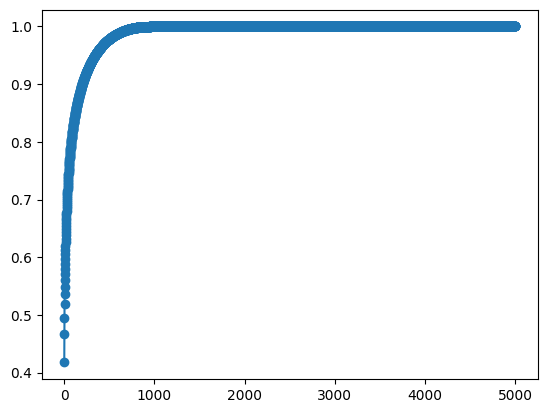

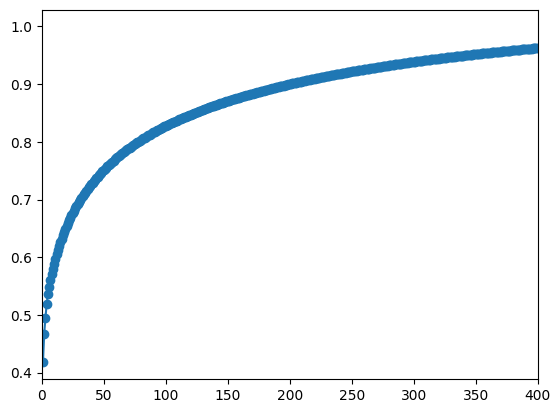

In [6]:
# Visualize
plt.figure(0)
plt.plot(range(1, X_train.shape[1] + 1), test_pca.explained_variance_ratio_.cumsum(), marker="o")
plt.figure(1)
plt.plot(range(1, X_train.shape[1] + 1), test_pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlim([0, 400])

### Machine Learning Approach _:
### Shallow Feed-Forward Classification Neural Network

In [154]:
NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Use PCA to reduce the dimensionality of the data
#pca = PCA(n_components=200)
#X_train_pca = pca.fit_transform(X_train)

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest = normalize(X_test)
ytest = y_test

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11719, 5000), Y Train Shape: (11719, 24)
X Val Shape: (2930, 5000), Y Val Shape: (2930, 24)
X Test Shape: (3663, 5000), Y Test Shape: (3663, 24)


In [157]:
l2_reg = 0.0001
def neural_network_train():
    layers = [
        Flatten(),
        Dense(25,
              activation="relu",
              #activity_regularizer=L1(0.01),
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              #activity_regularizer=L1(0.01),
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              #activity_regularizer=L1(0.01),
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              #activity_regularizer=L1(0.01),
              kernel_regularizer=L2(l2_reg)
        ),
        #BatchNormalization(),
        Dense(NUM_CLASSES, activation="softmax")
    ]

    model = Sequential(layers)
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['acc'])
    history = model.fit(xtrain, ytrain_1hot, batch_size=256, epochs=300, validation_data=(xval, yval_1hot))

    return model, history

nn_model, nn_history = neural_network_train()

Epoch 1/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.0665 - loss: 3.1882 - val_acc: 0.1191 - val_loss: 3.1769
Epoch 2/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1224 - loss: 3.1694 - val_acc: 0.1386 - val_loss: 3.1463
Epoch 3/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1456 - loss: 3.1319 - val_acc: 0.1457 - val_loss: 3.0925
Epoch 4/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1432 - loss: 3.0711 - val_acc: 0.1549 - val_loss: 3.0171
Epoch 5/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1526 - loss: 2.9915 - val_acc: 0.1341 - val_loss: 2.9311
Epoch 6/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.1386 - loss: 2.9028 - val_acc: 0.1372 - val_loss: 2.8468
Epoch 7/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.1393 - loss: 2.8199 - val_acc: 0.1440 - val_loss: 2.7680
Epoch 8/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1573 - loss: 2.7454 - val_acc: 0.1614 - val_loss: 2.6930
Epoch 9/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.1776

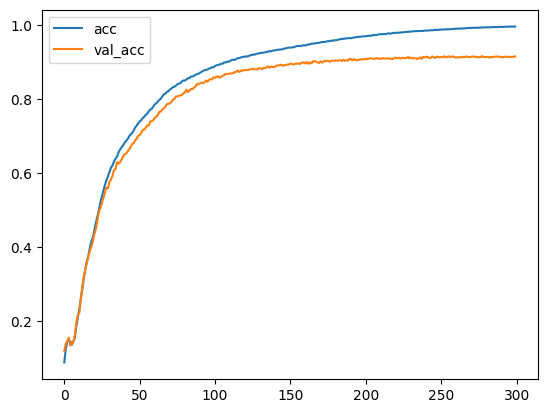

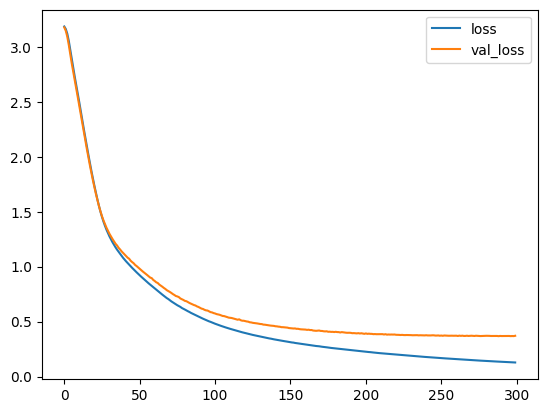

In [158]:
plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()